In [1099]:
from bs4 import BeautifulSoup
from requests_html import HTMLSession
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

>First order of business is extracting the HTML from the webpage using the BeautifulSoup package. There are three steps:
>1. Extract the HTML data as a soup
>2. Extract every html instance of element 'tr', or table row. This houses the data I need. 
>3. Create a pandas dataframe using the specific HTML data I need. 

I also rename the columns to "State" and "\\$kTaxes"  because they are easier to work with than the column names in the original Wikipedia table. To clarify, "\\$kTaxes" mean taxes in thousands of dollars.

In [1100]:
session = HTMLSession()
#The URL of the Wikipedia page I am scraping from.
URL = 'https://en.wikipedia.org/wiki/Federal_tax_revenue_by_state'
#Extracts the HTML from the webpage.
response = session.get(URL)
soup = BeautifulSoup(response.content, 'html.parser')
#Pulls the table data from the HTML.
table = soup.find('table', {'class': 'wikitable sortable'}).tbody
#Creates rows from the 'tr' elements in the HTML.
rows = table.find_all('tr')
df = pd.DataFrame(columns=column_names)
#Extracts data with the 'td' HTML element.
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')

#Removes the '/n' elements in the HTML code
    values = [td.text.replace('\n', '') for td in tds]
#Adds the data to a blank dataframe.
    df = df.append(pd.Series(values, index = column_names), ignore_index = True)
#Changes the original names of the columns to shorter ones.
df.columns = ['State', '$kTaxes']
df

,State,$kTaxes
0,Alabama,"26,511,031"
1,Alaska,"5,395,473"
2,Arizona,"47,743,166"
3,Arkansas,"30,572,215"
4,California,"472,027,235"
5,Colorado,"59,961,429"
6,Connecticut,"57,092,781"
7,Delaware,"20,073,979"
8,District of Columbia,"27,529,823"
9,Florida,"210,024,433"


>In order to work with the numbers, I need to remove the commas and then convert the numbers into an integer format. Next, I can sort the states by the amount of federal tax they collect.  I also want to eliminate territories that do not have voting power, as they are not relevant to my research objective.

In [1078]:
df['$kTaxes'] = [int(x.replace(',', '')) for x in df['$kTaxes']]
df.sort_values('$kTaxes', inplace = True)
df = df.drop([51, 52, 53])
#Updates the "Total" value
df = df.replace([3561904049], df[0:51]['$kTaxes'].sum())
df.reset_index(drop=True, inplace=True)
df

,State,$kTaxes
0,Vermont,4505097
1,Wyoming,4743997
2,Alaska,5395473
3,Montana,6356727
4,North Dakota,6639943
5,West Virginia,7039939
6,South Dakota,8029363
7,Maine,8130883
8,Hawaii,9246293
9,New Mexico,9270398


>I can now add two columns to the dataframe. The first column, 'topTax', is the sum of all tax revenue collected by a state and every state that collects more tax revenue than it. 'percentTotalTax' is the percentage this sum is of all of the federal tax revenue collected.

In [1079]:
#Creates a column that sums the federal tax revenue of a state and every state that collects more federal tax revenue than it.
list = []
for i in range(len(df)):
    list.append(df[i:-1]['$kTaxes'].sum())
list
df['topTax'] = list
total_tax = df.tail(1)['$kTaxes']
#Creates the 'percentTotal' column
df['percentTotalTax'] = [float(x/total_tax)*100 for x in df['topTax']]
#Rounds the decimals in the column to the nearest hundredth place
df['percentTotalTax'] = [float("{:.2f}".format(x)) for x in df['percentTotalTax']]
df


,State,$kTaxes,topTax,percentTotalTax
0,Vermont,4505097,3544993182,100.00
1,Wyoming,4743997,3540488085,99.87
2,Alaska,5395473,3535744088,99.74
3,Montana,6356727,3530348615,99.59
4,North Dakota,6639943,3523991888,99.41
5,West Virginia,7039939,3517351945,99.22
6,South Dakota,8029363,3510312006,99.02
7,Maine,8130883,3502282643,98.80
8,Hawaii,9246293,3494151760,98.57
9,New Mexico,9270398,3484905467,98.30


>I will use the same programming used to make the topTax and percentTotalTax columns again, so I store them as functions. 

In [1080]:
def backSum(df, column):
    list = []
    for i in range(len(df)):
        list.append(df[i:-1][column].sum())
    return list

In [1081]:
def percentTotal(dfColumn, total):
    list = [float(x/total)*100 for x in dfColumn]
    #Rounds the decimals in the column to the hundredth place
    list = [float("{:.2f}".format(x)) for x in list]
    return list

>In order to visualize the data, I first create a dataframe that only contains the data I want to visualize. This only includes the index and the 'percentTotalTax' column of the original dataframe.

In [1082]:
dfTax = df[['percentTotalTax']][::-1]
dfTax.reset_index(drop=True, inplace=True)
dfTax

,percentTotalTax
0,0.00
1,13.32
2,21.92
3,30.17
4,36.09
5,40.67
6,44.75
7,48.75
8,52.71
9,56.10


>Finally, I can graph the data. I decided to reveal the exact value of every sixth x coordinate so that the plot is easier to understand.

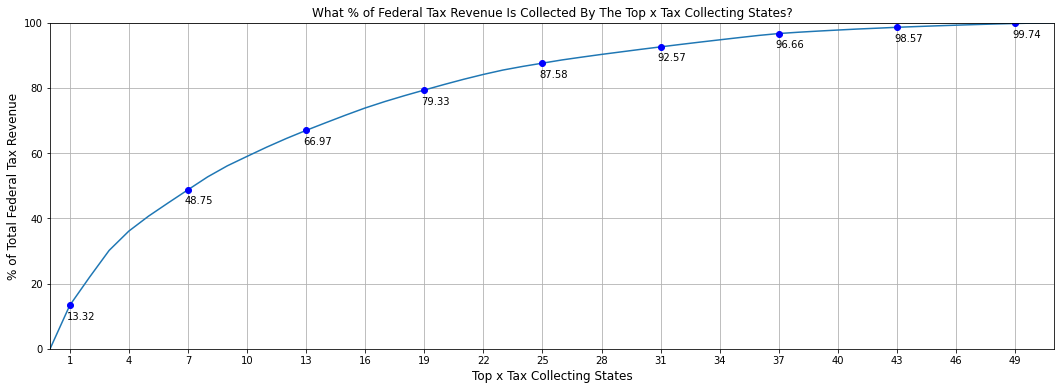

In [1083]:
fig = plt.figure(figsize = (18,6))
ax = fig.add_subplot(111)

#Plots the entire dfTax dataframe and creates specific points for every sixth value starting on 1.
plt.plot(dfTax) 
plt.plot(dfTax.iloc[[*range(1,52,6)]],'bo')

#Creates xticks in intervals of three.
plt.xticks([*range(1, 54, 3)]) 
#Makes the plot easier to read with a grid. 
plt.grid()
#Starts the line graph at (0,0)
plt.margins(0)
#Labels the top and x,y axis. 
plt.title('What % of Federal Tax Revenue Is Collected By The Top x Tax Collecting States?', fontsize = 12)
plt.xlabel('Top x Tax Collecting States', fontsize = 12)
plt.ylabel('% of Total Federal Tax Revenue', fontsize = 12)
#Labels the exact values of every sixth coordinate, starting with 1. 
for i, v in enumerate(dfTax['percentTotalTax']):
    if i in [*range(1,52,6)]:
        ax.annotate(str(v), xy=(i,v), xytext=(-3,-14), textcoords='offset points')

>I'll do that last operation more in the future, so I store it as another function. 

In [1084]:
def makeCoord(dfColumn, x, y):
    for i, v in enumerate(dfColumn):
        if i in [*range(1,31,6)] or i in [*range(31,52,6)]:
            ax.annotate(str(v), xy=(i,v), xytext=(x, y), textcoords='offset points')

>Some key findings I noticed were that nearly half of all federal tax revenue is collected by the top seven tax collecting states. They are California, New York, Texas, Florida, Illinois, Ohio, and Pennsylvania. Coincidentally or consequentially they are also the seven most populous states, however not in that order. 

# Part 2: Population and Electoral Votes 

>I will now compare this tax data with the data of the top x states' share of the population and electoral vote. In order to find population and electoral vote data state by state, I found a very well formatted csv file ready-made at this site: https://worldpopulationreview.com/state-rankings/electoral-votes-by-state.

In [1085]:
pDf = pd.read_csv('~/Downloads/csvData.csv')
pDf

,State,electoralVotesNumber,peoplePerElector,Pop
0,California,55,720245.4545,39613500
1,Texas,38,782376.3158,29730300
2,New York,29,665517.2414,19300000
3,Florida,29,756710.3448,21944600
4,Pennsylvania,20,640205.0000,12804100
5,Illinois,20,628465.0000,12569300
6,Ohio,18,650811.1111,11714600
7,Michigan,16,624526.8750,9992430
8,Georgia,16,676875.0000,10830000
9,North Carolina,15,713400.0000,10701000


>    After sorting the states by their population, I then add a 'Total' row so I can calculate the same percentages as my previous plot. I also drop the "peoplePerElector" column because, although it is an interesting metric, I do not need it for my analysis. I also add the population and electoral vote data of the District of Columbia, even though it is not a state, because I want to compare all territories with electoral voting power.

In [1086]:
#Removes the 'peoplePerElector' column. 
pDf.drop('peoplePerElector', axis=1, inplace = True)
#Adds the data of the District of Columbia
pDf = pDf.append({'State': 'District of Columbia', 'electoralVotesNumber': 3, 'Pop': 714153}, ignore_index = True)
#Creates a 'total' row.
pDf = pDf.append({'State': 'Total', 'electoralVotesNumber' : pDf.electoralVotesNumber.sum(), 'Pop': pDf.Pop.sum()}, ignore_index = True)
#Sorts the dataframe by population.
pDf = pDf.sort_values('Pop')
pDf

,State,electoralVotesNumber,Pop
43,Wyoming,3,581075
44,Vermont,3,623251
50,District of Columbia,3,714153
49,Alaska,3,724357
46,North Dakota,3,770026
45,South Dakota,3,896581
48,Delaware,3,990334
38,Rhode Island,4,1061510
47,Montana,3,1085000
40,Maine,4,1354520


>I need to append four new columns to this dataframe. The first column, 'topVotesCombined" counts the total electoral votes of each state on the list and all of the states below it. The second column, 'percentVotes', compares this sum with the total electoral votes. The 'topPopCombined' column does a similar computation as 'topVotesCombined' but with the population statistic. 'percentPop' is also the same idea as 'percentVotes' but with population.

In [1087]:
#Creates a column that sums the federal tax revenue of a state and every state that collects more federal tax revenue than it.
pDf['topVotesCombined'] = backSum(pDf, 'electoralVotesNumber')
#Pulls the total number of electoral votes from the last row of the dataframe.
total_votes = pDf.tail(1)['electoralVotesNumber']
#Creates a column for the percent the backsum is of the total electoral votes
pDf['percentTotalVotes'] = percentTotal(pDf['topVotesCombined'], total_votes)

#I do the same operations for the population metric.
pDf['topPopCombined'] = backSum(pDf, 'Pop')
total_pop = pDf.tail(1)['Pop']
pDf['percentTotalPop'] = percentTotal(pDf['topPopCombined'], total_pop)
pDf

,State,electoralVotesNumber,Pop,topVotesCombined,percentTotalVotes,topPopCombined,percentTotalPop
43,Wyoming,3,581075,538,100.00,331343487,100.00
44,Vermont,3,623251,535,99.44,330762412,99.82
50,District of Columbia,3,714153,532,98.88,330139161,99.64
49,Alaska,3,724357,529,98.33,329425008,99.42
46,North Dakota,3,770026,526,97.77,328700651,99.20
45,South Dakota,3,896581,523,97.21,327930625,98.97
48,Delaware,3,990334,520,96.65,327034044,98.70
38,Rhode Island,4,1061510,517,96.10,326043710,98.40
47,Montana,3,1085000,513,95.35,324982200,98.08
40,Maine,4,1354520,510,94.80,323897200,97.75


>Because I need to plot each of the 'percentTotal' values, I create dedicated dataframes for each value and reversed their indexes so they are ascending in value. 

In [1089]:
pDfVote = pDf[['percentTotalVotes']][::-1]
pDfVote.reset_index(drop=True, inplace=True)
pDfVote

,percentTotalVotes
0,0.00
1,10.22
2,17.29
3,22.68
4,28.07
5,31.78
6,35.50
7,38.85
8,41.82
9,44.61


In [1091]:
pDfPop = pDf[['percentTotalPop']][::-1]
pDfPop.reset_index(drop=True, inplace=True)
pDfPop

,percentTotalPop
0,0.00
1,11.96
2,20.93
3,27.55
4,33.38
5,37.24
6,41.03
7,44.57
8,47.84
9,51.07


>Finally, I can now plot the data. I compare the population, electoral vote, and Tax data of all 51  states/territories.

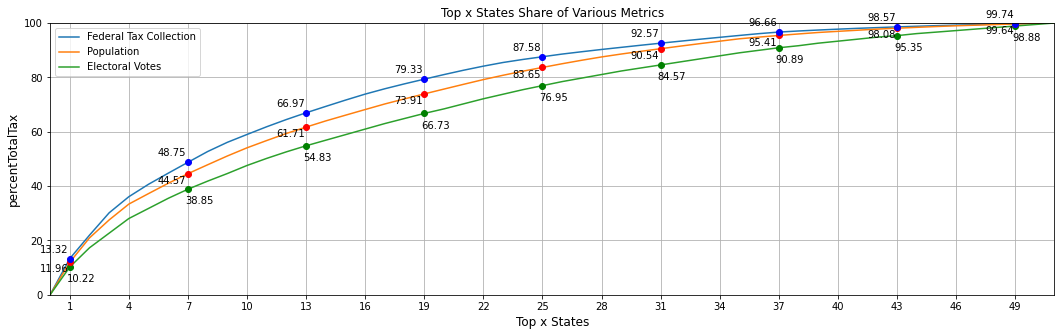

In [1093]:
fig = plt.figure(figsize = (18, 5))
ax = fig.add_subplot(111)


plt.plot(dfTax) 
plt.plot(pDfPop)
plt.plot(pDfVote)
plt.plot(pDfVote.iloc[[*range(1,52,6)]],'go')
plt.plot(pDfPop.iloc[[*range(1,52,6)]],'ro')
plt.plot(dfTax.iloc[[*range(1,52,6)]],'bo')
plt.xticks([*range(1, 54, 3)]) 
plt.margins(0)
plt.grid()

plt.title('Top x States Share of Various Metrics')
plt.xlabel('Top x States', fontsize = '12')
plt.ylabel('percentTotalTax', fontsize = '12')
plt.legend(['Federal Tax Collection', 'Population', 'Electoral Votes'])

makeCoord(pDfVote['percentTotalVotes'], -3, -15)
makeCoord(pDfPop['percentTotalPop'], -30, -10)
makeCoord(dfTax['percentTotalTax'], -30, 6)

>Of the three variables I calculated for, I found electoral votes are the most evenly distributed across states. While the top 7 tax collecting states collect nearly half of all federal taxes, those same seven states only control less than 40% of all of the electoral votes. In order to see how each state ranks in terms of federal tax collection and population/representation, I print the two dataframes holding this data side by side below. 

In [1094]:
#I make sure not to inlcude the total row and reverse the order so that the dataframes are in order from most to least. 
topTax = df[['State', '$kTaxes']][0:51][::-1]
#I modify the index so that it starts at 1 as opposed to 0 for better readability. 
topTax.index = np.arange(1, len(topTax) + 1)
topPop = pDf[['State','electoralVotesNumber', 'Pop']][0:51][::-1]
topPop.index = np.arange(1, len(topPop) + 1)
display(topTax)
display(topPop)

,State,$kTaxes
1,California,472027235
2,New York,304992923
3,Texas,292330171
4,Florida,210024433
5,Illinois,162274617
6,Ohio,144704811
7,Pennsylvania,141973579
8,New Jersey,140258435
9,Massachusetts,120035203
10,Minnesota,102642589


,State,electoralVotesNumber,Pop
1,California,55,39613500
2,Texas,38,29730300
3,Florida,29,21944600
4,New York,29,19300000
5,Pennsylvania,20,12804100
6,Illinois,20,12569300
7,Ohio,18,11714600
8,Georgia,16,10830000
9,North Carolina,15,10701000
10,Michigan,16,9992430


    I will now introduce a metric called "representationToTaxation" that determines how much further up or down a state is on the list of most populous states compared to their place on the list of most taxed states. I then add this metric to a dataframe that contains electoral votes, population, and total federal taxes metrics. For good measure, I also add a column that calculates the average federal tax paid by each citizen of the state. 
>For example, Texas has a value of "+1" in the "representationToTaxation" column. This means that, although it is number two on the list of most populous states, it is number three on the list of states that collect the most federal tax. New York has a value of "-2" which means that, although it is number four on the list of most populous states, it is number two on the list of states that collect the most federal tax. Since this is the end of my analysis, I also make the large numbers easier to read with commas every thousand.

In [1095]:
#Creates a list that is populated in order so that it can be directly inserted into the topPop dataframe.
representationToTaxation = []
#I simply compare the index of a state in the topTax dataframe (sorted by tax) with their position in the topPop dataframe (sorted by population).
for x in topPop['State'].tolist():
    r = topTax[topTax['State'] == x].index[0] - topPop[topPop['State'] == x].index[0]
    #Positive numbers have a "+" appended to the front. All other numbers are added as they are.
    if r > 0:
        representationToTaxation.append('+' + str(r))
    else:
        representationToTaxation.append(r)

#I start with the topPop dataframe which does not contain the tax data.
topStates = topPop
#This makes sure that I pull the tax data that exactly matches the state. A simple concat would add the tax data out of order. 
for x in topStates['State'].tolist():
    topStates.loc[topStates[topStates['State'] == x].index[0], '$kTaxes'] = int(topTax[topTax['State'] == x]['$kTaxes'])
#Calculates the average amount of federal tax a citizen of each state pays. 
topStates['averageFedTaxPerPerson'] = round(topStates['$kTaxes']/topStates['Pop']*1000)
#Adds the 'representationToTaxation' list I created in the above cell to the dataframe. 
topStates['representationToTaxation'] = representationToTaxation
#Adds commas for every thousands place. 
topStates['Pop'] = ['{:,}'.format(int(x)) for x in topStates['Pop']]
topStates['$kTaxes'] = ['{:,}'.format(int(x)) for x in topStates['$kTaxes']]
topStates['averageFedTaxPerPerson'] = ['{:,}'.format(int(x)) for x in topStates['averageFedTaxPerPerson']]
topStates    

,State,electoralVotesNumber,Pop,$kTaxes,averageFedTaxPerPerson,representationToTaxation
1,California,55,"39,613,500","472,027,235","11,916",0
2,Texas,38,"29,730,300","292,330,171","9,833",+1
3,Florida,29,"21,944,600","210,024,433","9,571",+1
4,New York,29,"19,300,000","304,992,923","15,803",-2
5,Pennsylvania,20,"12,804,100","141,973,579","11,088",+2
6,Illinois,20,"12,569,300","162,274,617","12,910",-1
7,Ohio,18,"11,714,600","144,704,811","12,353",-1
8,Georgia,16,"10,830,000","94,305,868","8,708",+4
9,North Carolina,15,"10,701,000","87,778,099","8,203",+4
10,Michigan,16,"9,992,430","81,583,480","8,165",+5


>I was surprised to find some states had a very large discrepancy between the amount of federal tax they collect and their population/representation. For example, Michigan and Arizona are placed 5 and 9 places higher respectively on the list of most represented states compared to the list of states that collect the most federal tax revenue. Meanwhile, Massachussets and Minnesota are placed 7 and 12 places lower respectively on the list of most represented states than they are on the list of most taxed states. However, I think it is a very good thing that our system is set up so that the influence a state has on governance has solely to do with its population and not the amount of federal tax revenue it collects.  